## Raw Convolutional Neural Network on Tensorflow

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load mnist dataset
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

In [3]:
X = train_data.drop(columns=['label'])
Y = train_data['label']
X.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# split train and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#convert labels as int
y_train  = y_train.astype(int)
y_test  = y_test.astype(int)

In [5]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
    
# one hot encode y values
y_train = np.array(y_train)
y_train = dense_to_one_hot(y_train)
y_test = np.array(y_test)
y_test = dense_to_one_hot(y_test)

x_train = np.array(x_train)
x_test = np.array(x_test)

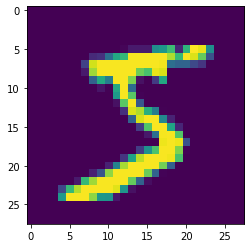

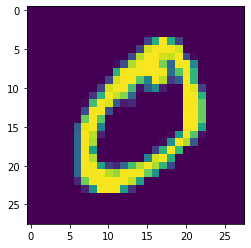

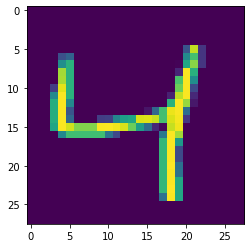

In [6]:
#test show images
# img size: 28x28
x_np = np.array(X)
for i in range(0,3):
    img_test = x_np[i].reshape(28,28)
    plt.imshow(img_test)
    plt.show()

In [36]:
# define hyper parameters
learning_rate = 0.001
epochs = 10

input_size = x_np.shape[1]
output_size = y_train.shape[1]
batch_size = 128

total_batch = int(len(x_train) / batch_size)

x_place = tf.placeholder("float", [None, input_size])
y_place = tf.placeholder("float", [None, output_size])
drop_place = tf.placeholder(tf.float32) # dropout (keep probability)

In [37]:
#define weights and biases
wc1 = tf.Variable(tf.random.normal([5,5,1,32]))
wc2 = tf.Variable(tf.random.normal([5,5,32,64]))
wd1 = tf.Variable(tf.random.normal([7*7*64, 1024]))
ow = tf.Variable(tf.random.normal([1024,output_size]))

bc1 = tf.Variable(tf.random.normal([32]))
bc2 = tf.Variable(tf.random.normal([64]))
bd1 = tf.Variable(tf.random.normal([1024]))
ob = tf.Variable(tf.random.normal([output_size]))

In [38]:
# create conv net
def conv2d(x,w,b,strides=1):
    conv = tf.nn.conv2d(x,w,strides=[1,strides,strides,1],padding='SAME')
    conv = tf.nn.bias_add(conv,b)
    acti = tf.nn.relu(conv) # apply acti
    return acti

def pool2d(x,k=2):
    pool = tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')
    return pool

def fc_layer(x,w,b,softmax=False):
    z = tf.add(tf.matmul(x,w),b)
    if softmax == False:
        a = tf.nn.relu(z)
    else:
        a = tf.nn.softmax(z)
    return a
    
x_input = tf.reshape(x_place,shape=[-1, 28, 28, 1])
#layer 1
conv1 = conv2d(x_input,wc1,bc1)
pool1 = pool2d(conv1,k=2)
#layer 2
conv2 = conv2d(pool1,wc2,bc2)
pool2 = pool2d(conv2,k=2)

#layer 3
dense1 = tf.reshape(pool2,shape=[-1,7*7*64])
fc1 = fc_layer(dense1,wd1,bd1)
fc1 = tf.nn.dropout(fc1, drop_place)
logit = tf.add(tf.matmul(fc1,ow),ob)

In [39]:
# train neural network
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit,labels=y_place)) #compute loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #create optimizer
train_opti = optimizer.minimize(loss)
#compute accuracy
pred = tf.nn.softmax(logit)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y_place, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# train neural network
init = tf.global_variables_initializer() #initialize all tf variables 
sess = tf.Session()
sess.run(init)
for e in range(epochs):
    avg_cost = 0
    avg_acc = 0
    #train per batch data
    for i in range(1,total_batch+1):
        #create training data batches
        batch_start = i *batch_size
        batch_end = batch_start + batch_size
        if batch_end > x_train.shape[0]:
            batch_end = x_train.shape[0]
        batch_x,batch_y = x_train[batch_start:batch_end,:],y_train[batch_start:batch_end,:]
        #train neural net
        _,loss_val,acc = sess.run([train_opti,loss,accuracy], feed_dict={x_place: batch_x, y_place: batch_y,
                                                                        drop_place:0.75})
        avg_cost += loss_val /total_batch
        avg_acc += acc /total_batch
    print(f"Epoch: {e+1} / Loss: {avg_cost} / Accuracy: {avg_acc}") 
    
sess.close()

Epoch: 1 / Loss: 1746112.7460937486 / Accuracy: 0.7653868140243897
Epoch: 2 / Loss: 265842.9989281633 / Accuracy: 0.915991806402439
Epoch: 3 / Loss: 146405.60358708067 / Accuracy: 0.9405487804878032
Epoch: 4 / Loss: 91829.37494491947 / Accuracy: 0.9526486280487799
Epoch: 5 / Loss: 65718.51437154632 / Accuracy: 0.9607707698170725
Epoch: 6 / Loss: 49745.541542611485 / Accuracy: 0.9653915777439018
Epoch: 7 / Loss: 39097.90583019721 / Accuracy: 0.9702982088414637
Epoch: 8 / Loss: 29597.186099168743 / Accuracy: 0.9736328124999993
Epoch: 9 / Loss: 22039.230589331648 / Accuracy: 0.9778963414634161
Epoch: 10 / Loss: 17965.011575838405 / Accuracy: 0.9802067454268298
